<a href="https://colab.research.google.com/github/arkham1994/Deep-Learning/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

#cd drive/My Drive

In [6]:
os.path.exists('drive/My Drive/Colab Notebooks/New folder/mask0.png')

True

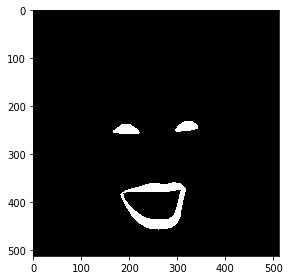

In [7]:
imshow('drive/My Drive/Colab Notebooks/New folder/mask0.png')

In [8]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

np.random.seed = 42

In [9]:
# Width and Height are decided based on the image as well as the computational power it requires

img_width = 128
img_height = 128
img_channel = 3

In [10]:
X_train = np.zeros((600, img_height, img_width, img_channel), dtype=np.uint8)
Y_train = np.zeros((600, img_height, img_width, 1), dtype= bool)

In [11]:
# Bulding the model for Eyes and Lips Segmentation based on U-Net architecture


inputs = tf.keras.layers.Input((img_width, img_height, img_channel))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

# Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
 
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
# Model Checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_img_segmentation.h5', verbose = 1, save_best_only = True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir = 'logs')]

#results = model.fit(X_train, Y_train, validation_split = 0.15, batch_size = 16, epochs = 25, callbacks = callbacks)


In [13]:
import os
folder = 'drive/My Drive/Colab Notebooks/images'
def load_images_from_folder(folder):
    images = []
    
    for i in range(0,600):
        img = imread(os.path.join(folder,'{}.jpg'.format(i)))[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_train[i] = img
        print(i)
    return None 
load_images_from_folder(folder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

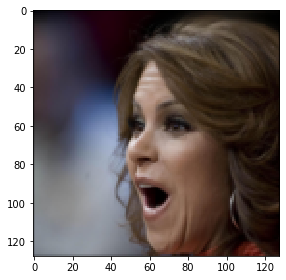

In [14]:
imshow(X_train[598])
plt.show()

In [19]:
for i in range(0,600):
    mask = np.zeros((img_height, img_width, 1), dtype = bool)
    path = 'drive/My Drive/Colab Notebooks/New folder/'
    im_gray = cv2.imread(path + 'mask{}.png'.format(i), cv2.IMREAD_GRAYSCALE)
    im_gray = resize(im_gray, (img_height, img_width), mode='constant', preserve_range=True)
    im_gray = np.expand_dims(im_gray,axis=2)
    mask = np.maximum(mask, im_gray)
    Y_train[i] = mask

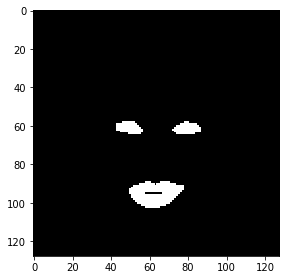

In [21]:
imshow(np.squeeze(Y_train[1]))

In [22]:
Y_train[0]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [23]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50)

Epoch 1/50
34/34 [==============================] - 36s 81ms/step - loss: 0.2688 - accuracy: 0.9642 - val_loss: 0.1650 - val_accuracy: 0.9736
Epoch 2/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0883 - accuracy: 0.9729 - val_loss: 0.0577 - val_accuracy: 0.9736
Epoch 3/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0502 - accuracy: 0.9731 - val_loss: 0.0421 - val_accuracy: 0.9737
Epoch 4/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0376 - accuracy: 0.9786 - val_loss: 0.0344 - val_accuracy: 0.9840
Epoch 5/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0303 - accuracy: 0.9870 - val_loss: 0.0436 - val_accuracy: 0.9793
Epoch 6/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0283 - accuracy: 0.9878 - val_loss: 0.0300 - val_accuracy: 0.9873
Epoch 7/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0264 - accuracy: 0.9887 - val_loss: 0.0288 - val_accuracy: 0.9875
Epoch 8/50
3

1/1 [==============================] - 1s 702ms/step


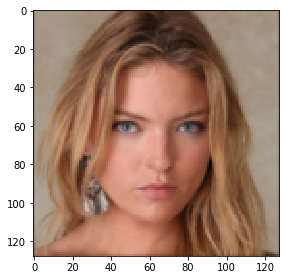

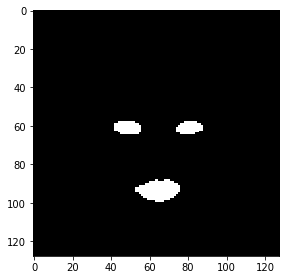

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


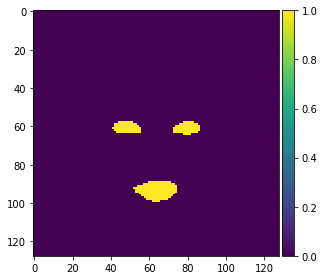

In [27]:

preds_train = model.predict(X_train[:10], verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)




 




# Perform a sanity check on some random training samples
ix = 5
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [26]:
model1 = load_model('/content/drive/My Drive/model_img_segmentation.h5')

OSError: ignored

In [25]:
from keras.models import Model, load_model

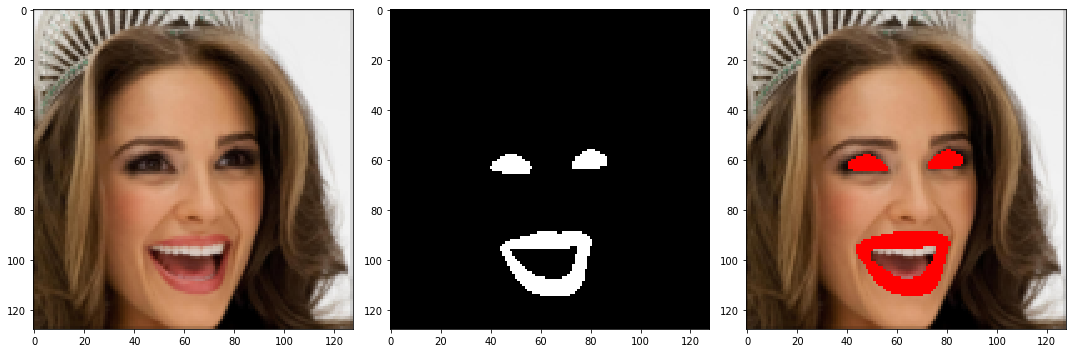

In [31]:

import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15, 9))
fig.add_subplot(1,3, 1)


from copy import deepcopy
im1=deepcopy(X_train[0][:,:,:])
imshow(im1)
fig.add_subplot(1,3, 2)
imshow(np.squeeze(Y_train[0]))
fig.add_subplot(1,3, 3)
im2=deepcopy(np.squeeze(preds_train_t[0])[:,:])
for i in range(im2.shape[0]):
  for j in range(im2.shape[1]):

    if(im2[i,j]!=0):
      im1[i,j,:]=[255,0,0]
imshow(im1)
plt.show()